# 3b. Modeling

In [31]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import (accuracy_score, f1_score, precision_recall_curve, auc, log_loss, classification_report,
confusion_matrix, plot_confusion_matrix, roc_curve)

In [11]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape, test.shape

((37500, 14), (12500, 14))

In [12]:
train.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,iPhone,city_King's Landing,city_Winterfell
0,0,2014-01-01,3.0,1.0,2014-06-16,0.0,1,100.0,3.90,4.0,1,1,1,0
1,2,2014-01-09,5.0,1.0,2014-06-08,0.0,1,50.0,2.64,4.9,1,1,0,1
2,1,2014-01-07,5.0,1.0,2014-01-08,0.0,0,100.0,15.74,5.0,0,0,0,0
3,1,2014-01-12,5.0,1.0,2014-01-12,0.0,0,0.0,3.09,5.0,0,1,0,1
4,2,2014-01-02,5.0,1.0,2014-05-19,0.0,0,75.0,11.79,4.3,0,0,0,0


In [17]:
X_train, y_train = train.drop(columns=['active', 'signup_date', 'last_trip_date']), train.active
X_test, y_test = test.drop(columns=['active', 'signup_date', 'last_trip_date']), test.active

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37500, 11), (37500,), (12500, 11), (12500,))

In [18]:
# Apply scaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def print_eval(model, X_tr, X_te, y_tr, y_te):
    """Quickly evaluate different models"""
    model.fit(X_tr, y_tr)
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)
    
    r2_tr, r2_te = r2_score(y_tr, y_tr_pred), r2_score(y_te, y_te_pred)
    rmse_tr, rmse_te = np.sqrt(mean_squared_error(y_tr, y_tr_pred)), np.sqrt(mean_squared_error(y_te, y_te_pred))
    mae_tr, mae_te = mean_absolute_error(y_tr, y_tr_pred), mean_absolute_error(y_te, y_te_pred)
    
    print(f"Train R2: {r2_tr:.2f}  |  Test R2: {r2_te:.2f} \n"
         f"Train RMSE: {rmse_tr:,.2f}  |  Test RMSE: {rmse_te:,.2f} \n"
         f"Train MAE: {mae_tr:,.2f}  |  Test MAE: {mae_te:,.2f}")

## 0. Baseline Model

In [24]:
pd.DataFrame({'Values':y_train.value_counts(), 'Perc':y_train.value_counts()/len(y_train)*100})

,Values,Perc
0,23740,63.306667
1,13760,36.693333


About 63% of users are not active, so our baseline model will predict that all users are inactive.

In [35]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
y_pred = dummy.predict(X_test_scaled)

print(classification_report(y_pred, y_test, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78     12500
           1       0.00      0.00      0.00         0

    accuracy                           0.64     12500
   macro avg       0.50      0.32      0.39     12500
weighted avg       1.00      0.64      0.78     12500



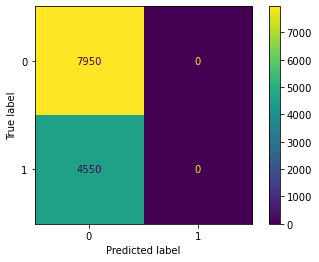

In [20]:
plot_confusion_matrix(dummy, X_test_scaled, y_test);

Baseline accuracy is 0.64

## I. Logistic Regression

In [37]:
LR = LogisticRegression(random_state=0)

LR.fit(X_train_scaled, y_train)
y_pred = LR.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      7950
           1       0.67      0.49      0.57      4550

    accuracy                           0.72     12500
   macro avg       0.71      0.67      0.68     12500
weighted avg       0.72      0.72      0.71     12500



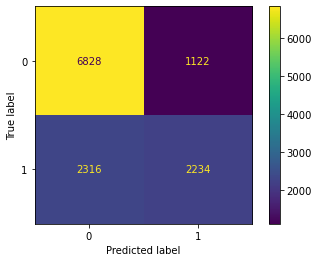

In [26]:
plot_confusion_matrix(LR, X_test_scaled, y_test);

In [48]:
# Make pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])

# Define param grid
c_range = [0.001, 0.1, 1, 10, 100]
penalty = ['l2', 'none']
solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
class_weight = [None, 'balanced']

param_grid = {'LR__C':c_range, 'LR__penalty':penalty, 'LR__solver':solver, 'LR__class_weight':class_weight}

In [49]:
scoring= ['accuracy', 'roc_auc', 'neg_log_loss']

LR_gridcv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
LR_gridcv.fit(X_train, y_train)

C:\Users\divzu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'LR__C': [0.001, 0.1, 1, 10, 100],
                         'LR__class_weight': [None, 'balanced'],
                         'LR__penalty': ['l2', 'none'],
                         'LR__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='accuracy')

In [50]:
LR_gridcv.best_estimator_, LR_gridcv.best_params_, LR_gridcv.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('LR',
                  LogisticRegression(C=0.001, penalty='none',
                                     solver='newton-cg'))]),
 {'LR__C': 0.001,
  'LR__class_weight': None,
  'LR__penalty': 'none',
  'LR__solver': 'newton-cg'},
 0.7254933333333333)

In [51]:
y_pred = LR_gridcv.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      7950
           1       0.67      0.49      0.57      4550

    accuracy                           0.73     12500
   macro avg       0.71      0.68      0.68     12500
weighted avg       0.72      0.73      0.71     12500



Accuracy of grid search CV LR model is only slightly better than the default LR settings.

## II. Random Forest Classifier

In [27]:
RF = RandomForestClassifier(random_state=0)

RF.fit(X_train_scaled, y_train)
y_pred = RF.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      7950
           1       0.68      0.66      0.67      4550

    accuracy                           0.77     12500
   macro avg       0.75      0.74      0.75     12500
weighted avg       0.76      0.77      0.77     12500



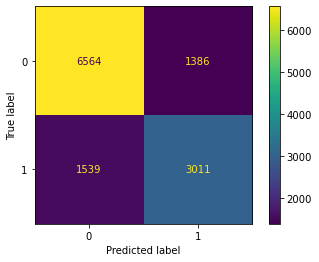

In [70]:
plot_confusion_matrix(RF, X_test_scaled, y_test);

In [53]:
[int(x) for x in np.linspace(start=10,stop=100,num=10)]

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [57]:
# Make pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier())])

# Define param grid
n_est = [int(x) for x in np.linspace(start=100,stop=1000,num=10)]
max_depth = [int(x) for x in np.linspace(start=10,stop=100,num=10)]
max_feat = ['sqrt', 'log2', None]
crit = ['gini', 'entropy']

param_grid = {'RF__n_estimators':n_est, 'RF__max_depth':max_depth, 'RF__max_features':max_feat, 'RF__criterion':crit}

In [66]:
%%time

scoring= ['accuracy', 'roc_auc', 'neg_log_loss']

RF_randcv = RandomizedSearchCV(pipeline, param_grid, scoring=scoring, refit='accuracy', cv=5, n_iter=75, n_jobs=-1)
RF_randcv.fit(X_train, y_train)

Wall time: 30min 43s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('RF', RandomForestClassifier())]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'RF__criterion': ['gini', 'entropy'],
                                        'RF__max_depth': [10, 20, 30, 40, 50,
                                                          60, 70, 80, 90, 100],
                                        'RF__max_features': ['sqrt', 'log2',
                                                             None],
                                        'RF__n_estimators': [100, 200, 300, 400,
                                                             500, 600, 700, 800,
                                                             900, 1000]},
                   refit='accuracy',
                   scoring=['accuracy', 'roc_auc', 'neg_log_loss'])

In [67]:
RF_randcv.best_estimator_, RF_randcv.best_params_, RF_randcv.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('RF',
                  RandomForestClassifier(criterion='entropy', max_depth=10,
                                         max_features='sqrt'))]),
 {'RF__n_estimators': 100,
  'RF__max_features': 'sqrt',
  'RF__max_depth': 10,
  'RF__criterion': 'entropy'},
 0.7876533333333333)

In [73]:
RF_best = RF_randcv.best_estimator_

y_pred = RF_best.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      7950
           1       0.74      0.65      0.69      4550

    accuracy                           0.79     12500
   macro avg       0.78      0.76      0.77     12500
weighted avg       0.79      0.79      0.79     12500



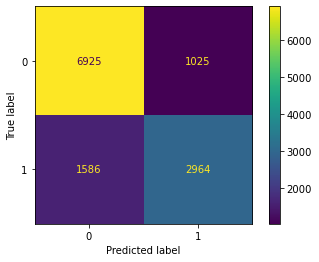

In [72]:
plot_confusion_matrix(RF_best, X_test, y_test);

## III. Gradient Boost Classifier

In [29]:
GB = GradientBoostingClassifier(random_state=0)

GB.fit(X_train_scaled, y_train)
y_pred = GB.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      7950
           1       0.74      0.66      0.69      4550

    accuracy                           0.79     12500
   macro avg       0.78      0.76      0.77     12500
weighted avg       0.79      0.79      0.79     12500



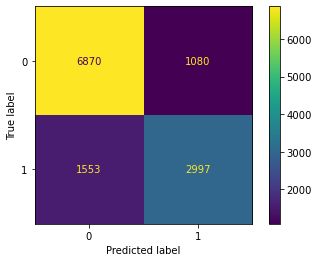

In [30]:
plot_confusion_matrix(GB, X_test_scaled, y_test);